# Credit Card Fraud Detection

In [143]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use("default")
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

pd.options.mode.chained_assignment = None

In [144]:
df = pd.read_csv("/Users/guillaumedenis/Programmation/Datasets/creditcard.csv")

print(df.info(), "\n")
df.columns = df.columns.str.lower()
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [145]:
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Splitting Data

In [146]:
print("There are", sum(df["class"]), "fraudulous transactions in the dataset.", "\n" )
print("Fraudulous transactions represent", round(sum(df["class"]) / df.shape[0] * 100, 2), 
      "% of all the observations.", "\n")

# Split data
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

# Make sure there's enough fraudulent observations in the training and testing dataset by using stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=43)

for index_train, index_test in sss.split(X, y):
    
    X_train, X_test = X.iloc[index_train], X.iloc[index_test]
    y_train, y_test = y.iloc[index_train], y.iloc[index_test]

    
# Standardise columns
norm_col = ["time", "amount"]

scaler = preprocessing.StandardScaler().fit(X_train[norm_col])

X_scaled_train = scaler.transform(X_train[norm_col])
X_scaled_test = scaler.transform(X_test[norm_col])

# Replace columns
X_train[norm_col] = X_scaled_train
X_test[norm_col] = X_scaled_test

# Data shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape, "\n")
print("There are", sum(y_train), "fraudulous transactions in the shuffled training dataset.")

There are 492 fraudulous transactions in the dataset. 

Fraudulous transactions represent 0.17 % of all the observations. 

(227845, 30)
(227845,)
(56962, 30)
(56962,) 

There are 394 fraudulous transactions in the shuffled training dataset.


In [147]:
# Balance training dataset
fraud_index = y_train[y_train == 1].index

# X and y with class==1
X_fraud = X_train[X_train.index.isin(fraud_index)]
y_fraud = y_train[y_train == 1]

# X and y with class==0
n_obs = 10000

X_non_fraud = X_train[~X_train.index.isin(fraud_index)].sample(frac=1, random_state = 101).iloc[0:n_obs]
y_non_fraud = y_train[y_train == 0].sample(frac=1, random_state = 101).iloc[0:n_obs]

# Append dataframes
X_bal = X_fraud.append(X_non_fraud).sample(frac = 1, random_state = 32).reset_index(drop = True)
y_bal = y_fraud.append(y_non_fraud).sample(frac = 1, random_state = 32).reset_index(drop = True)
df_bal = pd.concat([X_bal, y_bal], axis = 1)


## Graphics

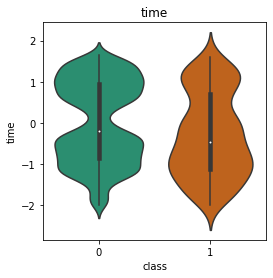

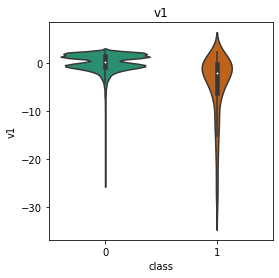

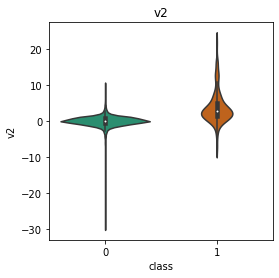

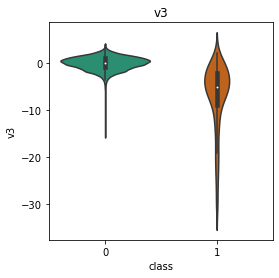

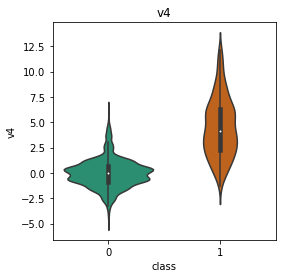

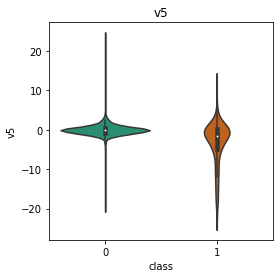

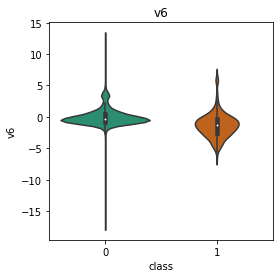

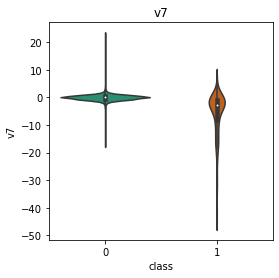

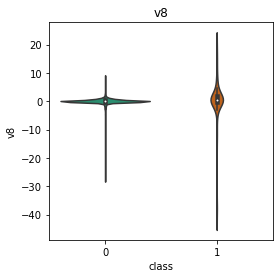

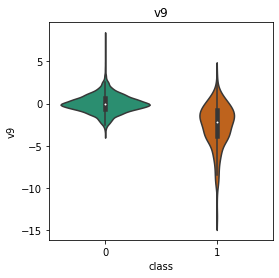

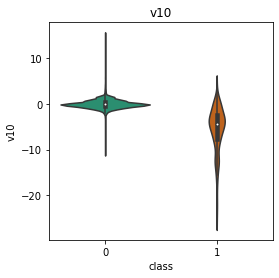

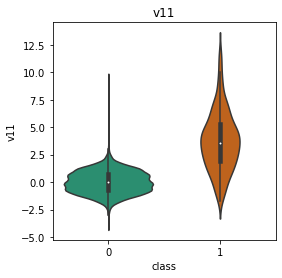

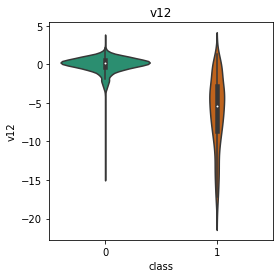

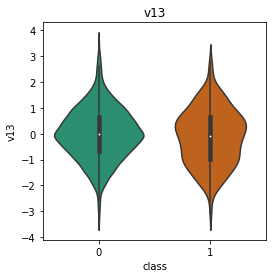

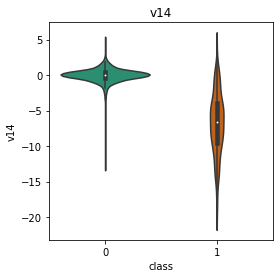

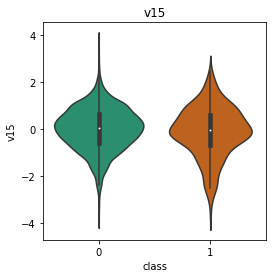

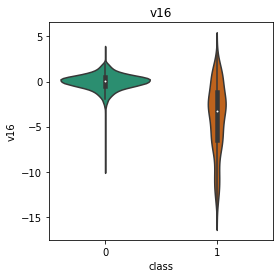

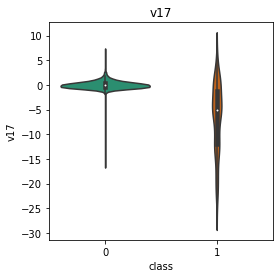

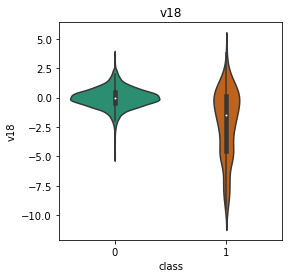

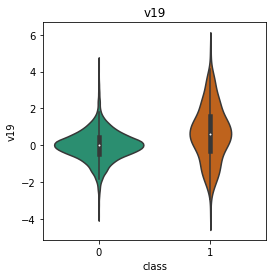

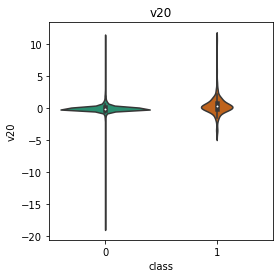

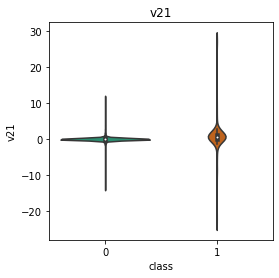

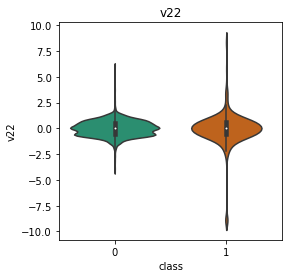

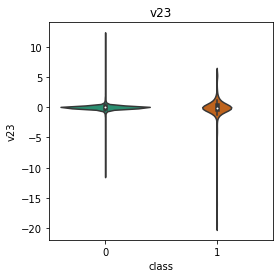

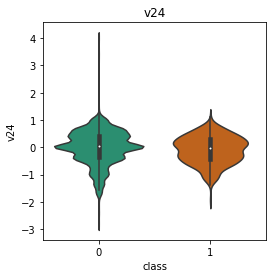

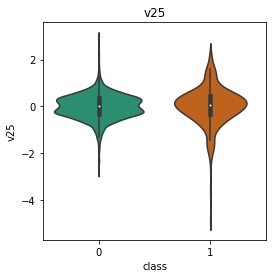

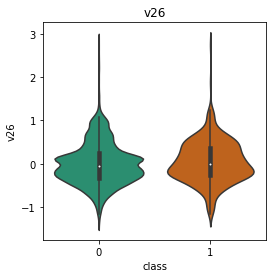

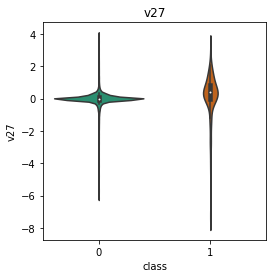

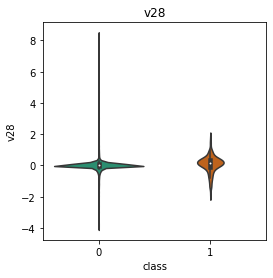

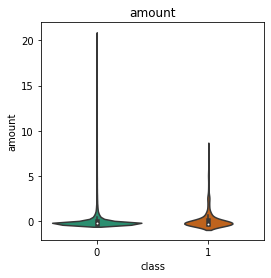

In [148]:
# Graphics for all columns
for column in df.columns[0:-1]:
    plt.figure(figsize = (4,4))
    sns.violinplot(x = "class", y = column, data = df_bal, palette = "Dark2").set_title(column)
    plt.show()



## Training Supervised Models

In [149]:
# Train models
models = {
    "SVM": SVC(kernel='rbf', gamma="auto"), # trop long à rouler
    "Linear SVM": LinearSVC(max_iter=100, tol=20, random_state=42),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(random_state = 2018, n_estimators = 100)
}

for name, model in models.items():
    model.fit(X_bal, y_bal)
    print(name + " trained.")

SVM trained.
Linear SVM trained.
Decision Tree trained.
Random Forest trained.


In [150]:
# Models score
for name, model in models.items():
    print(name + " Accuracy:", round(model.score(X_test, y_test),4))
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_pred, y_test)
    print("Precision:", conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1]))
    print("Recall:", conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0]))
    print("\n")

SVM Accuracy: 0.9992
Precision: 0.8571428571428571
Recall: 0.7368421052631579


Linear SVM Accuracy: 0.9929
Precision: 0.8775510204081632
Recall: 0.17954070981210857


Decision Tree Accuracy: 0.9918
Precision: 0.8571428571428571
Recall: 0.15700934579439252


Random Forest Accuracy: 0.9991
Precision: 0.8877551020408163
Recall: 0.6904761904761905


